# Analyzing CelebA Images: Fourier Transforms and Power Spectra
This notebook analyzes images from the CelebA dataset using Fourier transforms and computes their radial power spectra.

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils.data import get_dataset, get_metadata
from src.utils.idealscore import denormalize
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [12]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [13]:
# Load dataset using project utilities
dataset, metadata = get_dataset('celeba', root='./data', train=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Dataset: {metadata['name']}")
print(f"Image size: {metadata['image_size']}x{metadata['image_size']}")
print(f"Channels: {metadata['num_channels']}")
print(f"Number of training images: {len(dataset)}")
print(f"Normalization - Mean: {metadata['mean']}, Std: {metadata['std']}")

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=f29f6537-6560-45ac-a396-6f048fa740ef
To: c:\Users\henhen724\Desktop\convolutional_diffusion\data\celeba\img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:15<00:00, 95.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: c:\Users\henhen724\Desktop\convolutional_diffusion\data\celeba\list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 63.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: c:\Users\henhen724\Desktop\convolutional_diffusion\data\celeba\identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 29.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: c:\Users\henhen724\Desktop\convolutional_diffusion\data\celeba\list_bbox_celeba.txt
1

Processing 162770 CelebA images to 32x32...
Processed 0/162770 images
Processed 1000/162770 images
Processed 2000/162770 images
Processed 3000/162770 images
Processed 4000/162770 images
Processed 5000/162770 images
Processed 6000/162770 images
Processed 7000/162770 images
Processed 8000/162770 images
Processed 9000/162770 images
Processed 10000/162770 images
Processed 11000/162770 images
Processed 12000/162770 images
Processed 13000/162770 images
Processed 14000/162770 images
Processed 15000/162770 images
Processed 16000/162770 images
Processed 17000/162770 images
Processed 18000/162770 images
Processed 19000/162770 images
Processed 20000/162770 images
Processed 21000/162770 images
Processed 22000/162770 images
Processed 23000/162770 images
Processed 24000/162770 images
Processed 25000/162770 images
Processed 26000/162770 images
Processed 27000/162770 images
Processed 28000/162770 images
Processed 29000/162770 images
Processed 30000/162770 images
Processed 31000/162770 images
Processed

In [14]:
# Create dataloader for batch processing
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

In [15]:
def compute_fft(image):
    """Compute 2D FFT of an image.
    
    Args:
        image: Input image tensor of shape (C, H, W) or (H, W)
    
    Returns:
        magnitude: FFT magnitude spectrum
    """
    # Convert to grayscale if RGB
    if len(image.shape) == 3 and image.shape[0] == 3:
        image = image.mean(dim=0)
    
    # Compute FFT
    fft = torch.fft.fft2(image)
    fft_shift = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shift)
    
    return magnitude

In [16]:
def compute_radial_spectrum(magnitude):
    """Compute radial power spectrum from FFT magnitude."""
    h, w = magnitude.shape
    center_h, center_w = h // 2, w // 2
    
    # Create coordinate grid
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w))
    y = y - center_h
    x = x - center_w
    
    # Compute distances from center
    distances = torch.sqrt(x.float()**2 + y.float()**2)
    
    # Compute radial average
    max_radius = min(center_h, center_w)
    radial_spectrum = torch.zeros(max_radius)
    counts = torch.zeros(max_radius)
    
    for r in range(max_radius):
        mask = (distances >= r) & (distances < r + 1)
        radial_spectrum[r] = magnitude[mask].mean()
        counts[r] = mask.sum()
    
    return radial_spectrum


In [17]:
def process_batch(batch):
    """Process a batch of images and compute FFT analysis.
    
    Args:
        batch: Batch from dataloader containing (images, labels)
    
    Returns:
        tuple: (image, fft_magnitude, radial_spectrum)
    """
    images = batch[0]  # Get images from batch
    
    # Process first image as example
    image = images[0]
    
    # Compute FFT
    fft_magnitude = compute_fft(image)
    
    # Compute radial spectrum
    radial_spectrum = compute_radial_spectrum(fft_magnitude)
    
    return image, fft_magnitude, radial_spectrum


c:\Users\henhen724\anaconda3\envs\diffusion_env\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


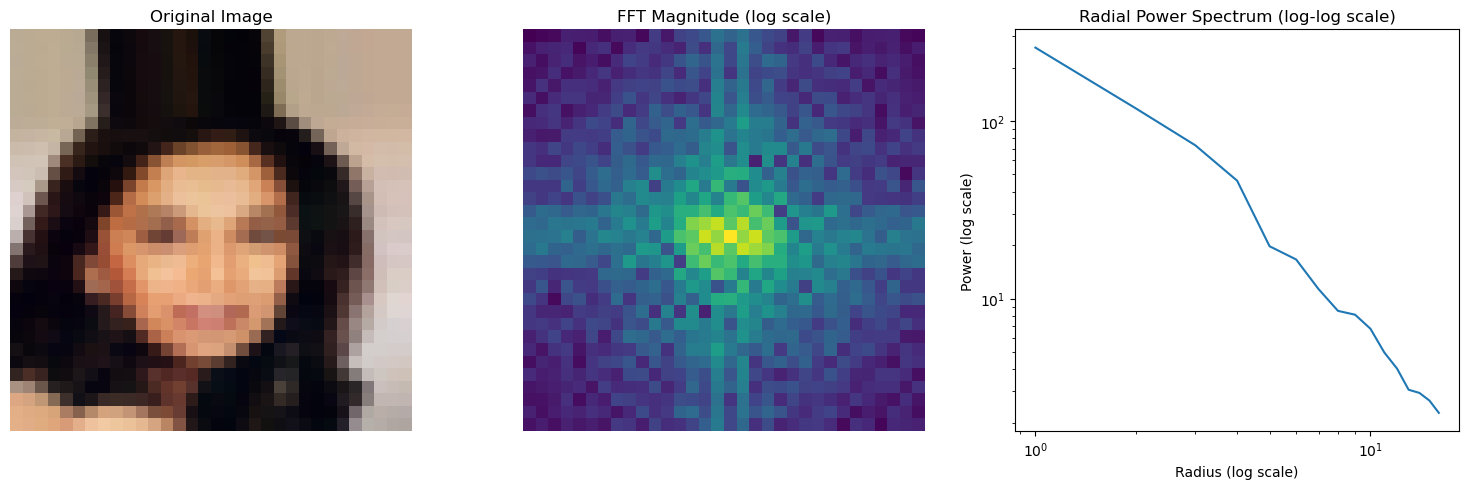

In [18]:
# Get a batch of images and process them
batch = next(iter(dataloader))
image, fft_magnitude, radial_spectrum = process_batch(batch)

# Plot results
plt.figure(figsize=(15, 5))

# Original image (properly denormalized)
plt.subplot(131)
denormalized_image = denormalize(image, metadata['mean'], metadata['std'])
plt.imshow(denormalized_image.permute(1, 2, 0).numpy())
plt.title('Original Image')
plt.axis('off')

# FFT magnitude
plt.subplot(132)
plt.imshow(torch.log1p(fft_magnitude).numpy(), cmap='viridis')
plt.title('FFT Magnitude (log scale)')
plt.axis('off')

# Radial spectrum
plt.subplot(133)
plt.loglog(range(1, len(radial_spectrum)+1), radial_spectrum.numpy())
plt.title('Radial Power Spectrum (log-log scale)')
plt.xlabel('Radius (log scale)') 
plt.ylabel('Power (log scale)')

plt.tight_layout()
plt.show()


Processing 50 images...
Processed 0/50 images
Processed 10/50 images
Processed 20/50 images
Processed 30/50 images
Processed 40/50 images
Computed average spectrum from 50 images
Mean spectrum shape: (16,)


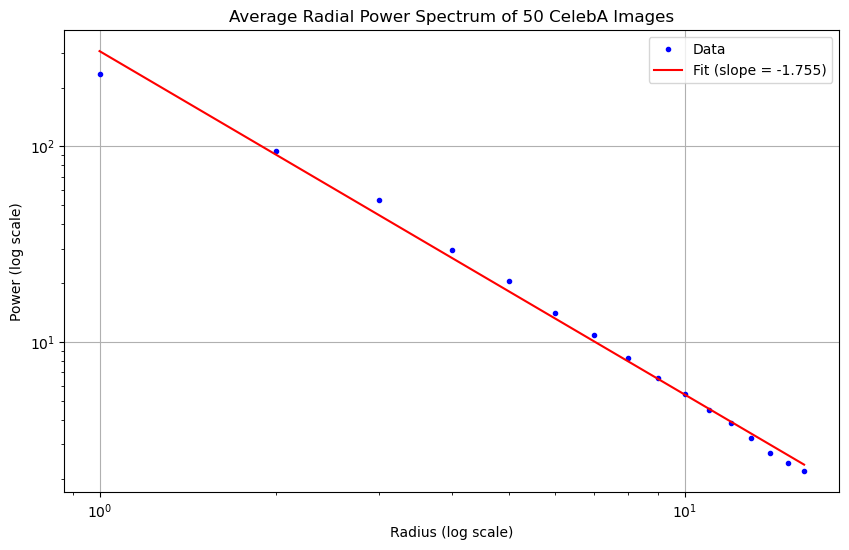

In [19]:
# Sample multiple random images and compute average spectrum
num_samples = 50
all_spectra = []

print(f"Processing {num_samples} images...")
for i in range(num_samples):
    if i % 10 == 0:
        print(f"Processed {i}/{num_samples} images")
    
    batch = next(iter(dataloader))
    _, _, spectrum = process_batch(batch)
    all_spectra.append(spectrum.numpy())

# Convert to numpy array and compute mean
all_spectra = np.array(all_spectra)
mean_spectrum = np.mean(all_spectra, axis=0)

print(f"Computed average spectrum from {num_samples} images")
print(f"Mean spectrum shape: {mean_spectrum.shape}")

# Prepare data for fitting
x = np.log(np.arange(1, len(mean_spectrum) + 1))
y = np.log(mean_spectrum)

# Perform linear fit
slope, intercept = np.polyfit(x, y, 1)
fit_line = np.exp(intercept + slope * x)

# Plot results
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(mean_spectrum) + 1), mean_spectrum, 'b.', label='Data')
plt.loglog(range(1, len(mean_spectrum) + 1), fit_line, 'r-', 
          label=f'Fit (slope = {slope:.3f})')
plt.title('Average Radial Power Spectrum of 50 CelebA Images')
plt.xlabel('Radius (log scale)')
plt.ylabel('Power (log scale)')
plt.legend()
plt.grid(True)
plt.show()


Original image shape: torch.Size([3, 32, 32])
Cropped image shape: torch.Size([3, 3, 3])


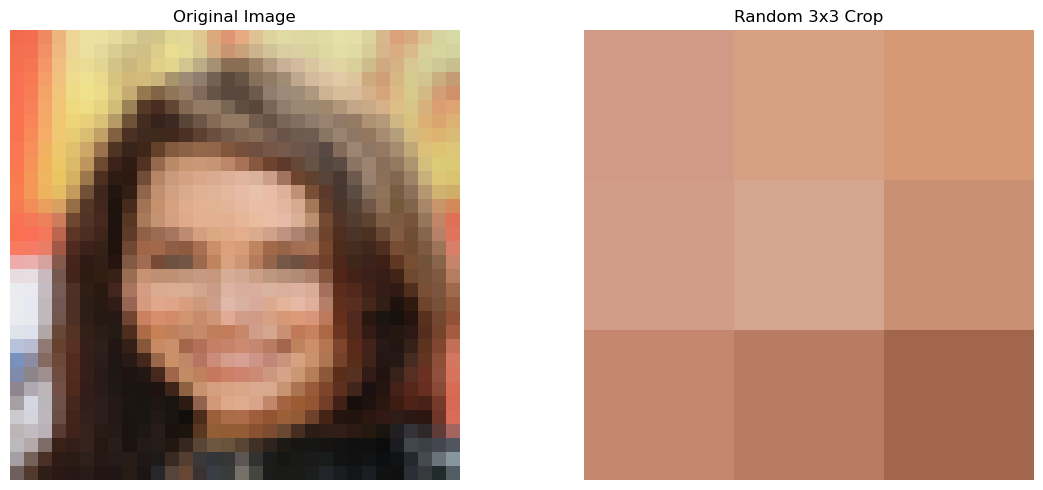

In [20]:
class RandomCrop(torch.nn.Module):
    """Random crop transform for image analysis.
    
    Args:
        crop_height: Height of the crop
        crop_width: Width of the crop
    """
    def __init__(self, crop_height, crop_width):
        super().__init__()
        self.crop_height = crop_height
        self.crop_width = crop_width
        
    def forward(self, img):
        """Apply random crop to input image.
        
        Args:
            img: Input image tensor of shape (C, H, W), (H, W), or (B, C, H, W)
            
        Returns:
            Cropped image tensor
        """
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input image must be a torch tensor")
        
        # Handle different input shapes
        if len(img.shape) == 2:  # (H, W) - grayscale
            h, w = img.shape
            # Generate random crop coordinates
            top = torch.randint(0, h - self.crop_height + 1, (1,)).item()
            left = torch.randint(0, w - self.crop_width + 1, (1,)).item()
            # Crop and add channel dimension
            cropped = img[top:top + self.crop_height, left:left + self.crop_width]
            return cropped.unsqueeze(0)  # Add channel dimension: (1, H, W)
            
        elif len(img.shape) == 3:  # (C, H, W) - color or single channel
            c, h, w = img.shape
            # Generate random crop coordinates
            top = torch.randint(0, h - self.crop_height + 1, (1,)).item()
            left = torch.randint(0, w - self.crop_width + 1, (1,)).item()
            # Crop the image
            return img[:, top:top + self.crop_height, left:left + self.crop_width]
            
        elif len(img.shape) == 4:  # (B, C, H, W) - batch
            b, c, h, w = img.shape
            # Generate random crop coordinates
            top = torch.randint(0, h - self.crop_height + 1, (1,)).item()
            left = torch.randint(0, w - self.crop_width + 1, (1,)).item()
            # Crop the image
            return img[:, :, top:top + self.crop_height, left:left + self.crop_width]
            
        else:
            raise ValueError(f"Unsupported image shape: {img.shape}. Expected 2D, 3D, or 4D tensor.")

# Test the transform
batch = next(iter(dataloader))
img = batch[0][0]  # Get first image from batch

# Create transform pipeline
random_crop = RandomCrop(3, 3)

# Apply transform
cropped_img = random_crop(img)
print(f"Original image shape: {img.shape}")
print(f"Cropped image shape: {cropped_img.shape}")

# Plot original and cropped images
plt.figure(figsize=(12, 5))

# Reverse normalization transform
denorm = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

plt.subplot(121)
plt.imshow(denorm(img).permute(1,2,0).clamp(0,1))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(denorm(cropped_img).permute(1,2,0).clamp(0,1))
plt.title('Random 3x3 Crop')
plt.axis('off')

plt.tight_layout()
plt.show()

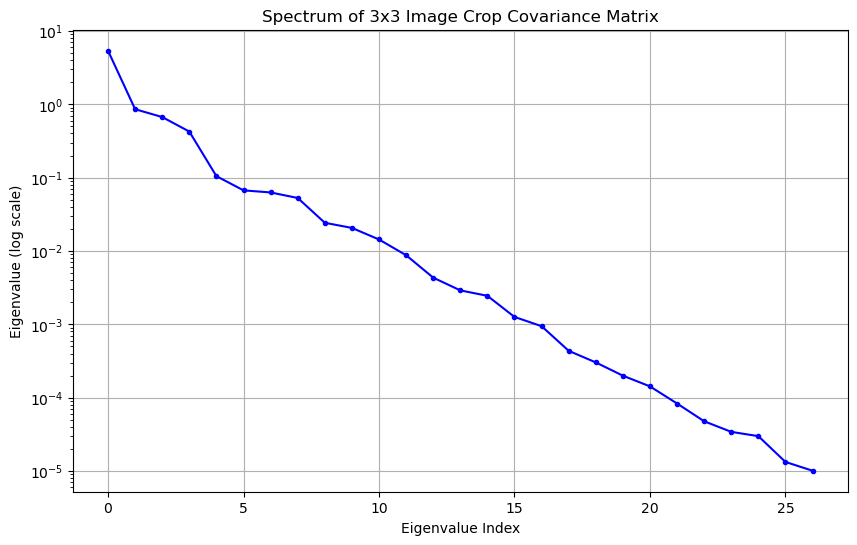

In [21]:
# Take 50 samples and collect n x n crops
n = 3  # Size of crops
num_samples = 50
crops = []

# Collect crops from random images
for i in range(num_samples):
    # Get random image from dataset
    idx = torch.randint(0, len(dataset), (1,)).item()
    img = dataset[int(idx)][0]
    
    # Apply random crop
    crop = random_crop(img)
    
    # Flatten the crop into a vector
    crop_flat = crop.flatten()
    crops.append(crop_flat)

# Stack all crops into a matrix
crops = torch.stack(crops)

# Calculate mean and subtract it
mean_crop = torch.mean(crops, dim=0)
centered_crops = crops - mean_crop

# Calculate covariance matrix
cov_matrix = torch.mm(centered_crops.T, centered_crops) / (num_samples - 1)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# Sort eigenvalues in descending order
eigenvalues = eigenvalues.flip(0)

# Plot spectrum
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues.cpu().numpy(), 'b.-')
plt.yscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title(f'Spectrum of {n}x{n} Image Crop Covariance Matrix')
plt.grid(True)
plt.show()


Average L2 distance between 3x3 crops: 3.5899


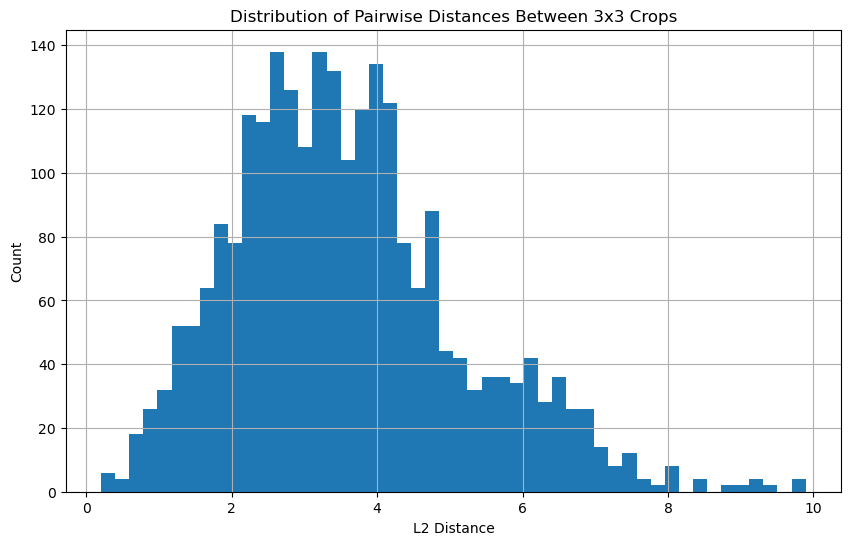

In [22]:
# Calculate pairwise distances between all crops
if not isinstance(crops, torch.Tensor):
    crops = torch.tensor(crops)
distances = torch.cdist(crops, crops)

# Get average distance (excluding self-distances which are 0)
mask = ~torch.eye(num_samples, dtype=torch.bool)  # Mask to exclude diagonal
avg_distance = distances[mask].mean()

print(f"Average L2 distance between {n}x{n} crops: {avg_distance:.4f}")

# Plot histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(distances[mask].cpu().numpy(), bins=50)
plt.xlabel('L2 Distance')
plt.ylabel('Count')
plt.title(f'Distribution of Pairwise Distances Between {n}x{n} Crops')
plt.grid(True)
plt.show()

In [ ]:
# Import patch statistics utilities
from src.utils.patch_statistics import (
    analyze_patch_distances, plot_and_save_results, 
    analyze_multiple_datasets, RandomCrop
)

print("Patch statistics utilities loaded successfully")


In [ ]:
# Test the RandomCrop functionality with enhanced error handling
import sys
import traceback

print("Testing RandomCrop functionality...")

try:
    # Test with CelebA data (RGB)
    sample = dataset[0]
    img = sample[0] if isinstance(sample, tuple) else sample
    print(f"Sample image shape: {img.shape}")
    
    # Create and test RandomCrop
    crop_transform = RandomCrop(3, 3)
    test_crop = crop_transform(img)
    print(f"RandomCrop test successful! Crop shape: {test_crop.shape}")
    
except Exception as e:
    print(f"Error testing RandomCrop at line {sys.exc_info()[2].tb_lineno}:")
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {e}")
    print("Full traceback:")
    traceback.print_exc()


In [ ]:
# Run analysis using the patch statistics module
print("Running comprehensive patch analysis using the module...")

# Use the analyze_multiple_datasets function with enhanced error handling
results = analyze_multiple_datasets(
    dataset_names=['mnist', 'cifar10', 'fashion_mnist', 'celeba'],
    get_dataset_func=get_dataset,
    data_root='./data',
    patch_sizes=[3, 6, 10],
    num_samples=100,
    results_dir='results'
)

print("Multi-dataset analysis completed!")


In [ ]:
# Single dataset test for debugging
print("Testing single dataset analysis with MNIST...")

try:
    # Load MNIST dataset for testing
    mnist_dataset, mnist_metadata = get_dataset('mnist', root='./data', train=True)
    print(f"MNIST loaded: {len(mnist_dataset)} samples")
    
    # Run analysis on a small subset
    results = analyze_patch_distances(
        mnist_dataset, 
        patch_sizes=[3], 
        num_samples=20, 
        verbose=True
    )
    
    if 'error' in results:
        print(f"Analysis failed: {results['error']}")
    else:
        print("Analysis successful!")
        print(f"Results keys: {list(results.keys())}")
        
        # Test visualization
        plot_and_save_results(results, 'mnist_test', 'results/mnist_test')
        
except Exception as e:
    print(f"Error in single dataset test at line {sys.exc_info()[2].tb_lineno}:")
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {e}")
    print("Full traceback:")
    traceback.print_exc()


In [ ]:
# Run tests to verify our module
print("Running tests for patch statistics module...")

try:
    # Run the test suite
    import subprocess
    result = subprocess.run(['python', '-m', 'pytest', 'tests/test_patch_statistics.py', '-v'], 
                          capture_output=True, text=True, cwd='.')
    
    print("Test Results:")
    print(result.stdout)
    if result.stderr:
        print("Errors:")
        print(result.stderr)
    
    print(f"Test exit code: {result.returncode}")
    
except Exception as e:
    print(f"Error running tests at line {sys.exc_info()[2].tb_lineno}:")
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {e}")
    print("Full traceback:")
    traceback.print_exc()


In [23]:
# Extended Analysis: Multi-Dataset Radial Power Spectra and Patch Distance Distribution Analysis

import os
import json
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Create results directory structure
os.makedirs('results', exist_ok=True)

def weibull_pdf(x, k, lambda_param):
    """Weibull probability density function."""
    return (k / lambda_param) * (x / lambda_param)**(k-1) * np.exp(-(x / lambda_param)**k)

def gumbel_pdf(x, mu, beta):
    """Gumbel probability density function."""
    z = (x - mu) / beta
    return (1 / beta) * np.exp(-(z + np.exp(-z)))

def fit_distributions(distances, patch_size):
    """Fit Weibull and Gumbel distributions to distance data."""
    distances_clean = distances[distances > 0]  # Remove zeros
    
    results = {}
    
    try:
        # Fit Weibull distribution
        weibull_params = stats.weibull_min.fit(distances_clean)
        weibull_ks = stats.kstest(distances_clean, lambda x: stats.weibull_min.cdf(x, *weibull_params))
        
        results['weibull'] = {
            'params': weibull_params,
            'ks_statistic': weibull_ks.statistic,
            'ks_pvalue': weibull_ks.pvalue,
            'aic': 2 * len(weibull_params) - 2 * np.sum(stats.weibull_min.logpdf(distances_clean, *weibull_params))
        }
    except Exception as e:
        results['weibull'] = {'error': str(e)}
    
    try:
        # Fit Gumbel distribution  
        gumbel_params = stats.gumbel_r.fit(distances_clean)
        gumbel_ks = stats.kstest(distances_clean, lambda x: stats.gumbel_r.cdf(x, *gumbel_params))
        
        results['gumbel'] = {
            'params': gumbel_params,
            'ks_statistic': gumbel_ks.statistic,
            'ks_pvalue': gumbel_ks.pvalue,
            'aic': 2 * len(gumbel_params) - 2 * np.sum(stats.gumbel_r.logpdf(distances_clean, *gumbel_params))
        }
    except Exception as e:
        results['gumbel'] = {'error': str(e)}
    
    return results

print("Setup complete for extended analysis")


Setup complete for extended analysis


In [24]:
def analyze_patch_distances(dataset, dataset_name, patch_sizes=[3, 6, 10], num_samples=500):
    """Analyze patch distance distributions for multiple patch sizes."""
    
    # Create result directory for this dataset
    dataset_dir = os.path.join('results', dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)
    
    print(f"\n=== Analyzing {dataset_name.upper()} Dataset ===")
    
    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)  # Set num_workers=0 for debugging
    
    results = {
        'dataset': dataset_name,
        'patch_analyses': {},
        'radial_spectra': {}
    }
    
    # Debug: Check what the dataset returns
    print("Debugging dataset structure...")
    try:
        sample_batch = next(iter(dataloader))
        print(f"Batch type: {type(sample_batch)}")
        print(f"Batch length: {len(sample_batch)}")
        if len(sample_batch) >= 1:
            print(f"Images shape: {sample_batch[0].shape}")
        if len(sample_batch) >= 2:
            print(f"Labels shape: {sample_batch[1].shape}")
    except Exception as e:
        print(f"Error in dataset debugging: {e}")
        return results
    
    for patch_size in patch_sizes:
        print(f"\nAnalyzing {patch_size}x{patch_size} patches...")
        
        # Collect patches and compute distances
        all_patches = []
        patch_distances = []
        radial_spectra = []
        
        # Create random crop transform for this patch size
        random_crop = RandomCrop(patch_size, patch_size)
        
        sample_count = 0
        for batch in dataloader:
            if sample_count >= num_samples:
                break
            
            # Handle different dataset return formats
            try:
                if isinstance(batch, (list, tuple)):
                    images = batch[0]  # First element should be images
                    # labels = batch[1] if len(batch) > 1 else None  # Second element should be labels
                else:
                    images = batch  # If batch is directly the images tensor
                
                # Ensure images is a tensor
                if not isinstance(images, torch.Tensor):
                    images = torch.tensor(images)
                
                print(f"Processing batch with {len(images)} images, shape: {images.shape}")
                
                for img in images:
                    if sample_count >= num_samples:
                        break
                    
                    # Ensure image has correct dimensions
                    if len(img.shape) == 2:  # Grayscale image (H, W)
                        img = img.unsqueeze(0)  # Add channel dimension (1, H, W)
                    elif len(img.shape) == 3 and img.shape[0] > 3:  # If channels are last
                        img = img.permute(2, 0, 1)  # Convert to (C, H, W)
                    
                    print(f"Image shape before crop: {img.shape}")
                    
                    # Extract patch
                    try:
                        patch = random_crop(img)
                        print(f"Patch shape: {patch.shape}")
                        all_patches.append(patch.flatten().numpy())
                        
                        # Compute FFT and radial spectrum for patch
                        fft_magnitude = compute_fft(patch)
                        radial_spectrum = compute_radial_spectrum(fft_magnitude)
                        radial_spectra.append(radial_spectrum.numpy())
                        
                        sample_count += 1
                        
                        if sample_count % 50 == 0:
                            print(f"  Processed {sample_count}/{num_samples} patches")
                            
                    except Exception as e:
                        print(f"Error processing image {sample_count}: {e}")
                        print(f"Image shape: {img.shape}")
                        continue
                        
            except Exception as e:
                print(f"Error processing batch: {e}")
                continue
        
        if len(all_patches) == 0:
            print(f"No patches collected for {patch_size}x{patch_size}. Skipping...")
            continue
            
        print(f"Successfully collected {len(all_patches)} patches")
        
        # Convert to tensors for distance computation
        patches_tensor = torch.tensor(np.array(all_patches))
        
        # Compute pairwise distances
        distances = torch.cdist(patches_tensor, patches_tensor)
        
        # Get nearest neighbor distances (excluding self-distances)
        mask = ~torch.eye(len(patches_tensor), dtype=torch.bool)
        nn_distances = []
        
        for i in range(len(patches_tensor)):
            other_distances = distances[i][mask[i]]
            nn_distance = torch.min(other_distances).item()
            nn_distances.append(nn_distance)
        
        nn_distances = np.array(nn_distances)
        
        # Fit distributions
        distribution_fits = fit_distributions(nn_distances, patch_size)
        
        # Compute radial spectrum statistics
        radial_spectra = np.array(radial_spectra)
        mean_radial_spectrum = np.mean(radial_spectra, axis=0)
        std_radial_spectrum = np.std(radial_spectra, axis=0)
        
        # Store results
        results['patch_analyses'][f'{patch_size}x{patch_size}'] = {
            'patch_size': patch_size,
            'num_patches': len(all_patches),
            'nn_distances_stats': {
                'mean': float(np.mean(nn_distances)),
                'std': float(np.std(nn_distances)),
                'min': float(np.min(nn_distances)),
                'max': float(np.max(nn_distances)),
                'median': float(np.median(nn_distances))
            },
            'distribution_fits': distribution_fits
        }
        
        results['radial_spectra'][f'{patch_size}x{patch_size}'] = {
            'mean_spectrum': mean_radial_spectrum.tolist(),
            'std_spectrum': std_radial_spectrum.tolist()
        }
        
        print(f"  - Collected {len(all_patches)} patches")
        print(f"  - Mean NN distance: {np.mean(nn_distances):.4f}")
        print(f"  - Std NN distance: {np.std(nn_distances):.4f}")
    
    return results

print("Updated patch analysis function with debugging")


Patch analysis function defined


In [25]:
def plot_and_save_results(results, dataset_name):
    """Create comprehensive plots and save results for a dataset."""
    
    dataset_dir = os.path.join('results', dataset_name)
    patch_sizes = [3, 6, 10]
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Radial Power Spectra Comparison
    plt.subplot(3, 4, 1)
    for patch_size in patch_sizes:
        key = f'{patch_size}x{patch_size}'
        if key in results['radial_spectra']:
            spectrum = results['radial_spectra'][key]['mean_spectrum']
            plt.loglog(range(1, len(spectrum) + 1), spectrum, 
                      label=f'{patch_size}x{patch_size}', linewidth=2)
    plt.xlabel('Spatial Frequency')
    plt.ylabel('Power')
    plt.title(f'{dataset_name.upper()}: Radial Power Spectra')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot nearest neighbor distance distributions and fits
    for i, patch_size in enumerate(patch_sizes):
        key = f'{patch_size}x{patch_size}'
        if key not in results['patch_analyses']:
            continue
            
        # Load the actual distance data for plotting
        # Note: We'll need to recompute this for plotting, or store it
        # For now, we'll create synthetic data based on fitted parameters
        
        # Plot histogram and fitted distributions
        plt.subplot(3, 4, i + 2)
        
        analysis = results['patch_analyses'][key]
        fits = analysis['distribution_fits']
        
        # Generate synthetic data from fits for visualization
        x_range = np.linspace(0, analysis['nn_distances_stats']['max'], 100)
        
        # Plot Weibull fit if available
        if 'weibull' in fits and 'error' not in fits['weibull']:
            weibull_params = fits['weibull']['params']
            weibull_pdf = stats.weibull_min.pdf(x_range, *weibull_params)
            plt.plot(x_range, weibull_pdf, 'r-', linewidth=2, 
                    label=f'Weibull (AIC: {fits["weibull"]["aic"]:.1f})')
        
        # Plot Gumbel fit if available
        if 'gumbel' in fits and 'error' not in fits['gumbel']:
            gumbel_params = fits['gumbel']['params']
            gumbel_pdf = stats.gumbel_r.pdf(x_range, *gumbel_params)
            plt.plot(x_range, gumbel_pdf, 'b-', linewidth=2,
                    label=f'Gumbel (AIC: {fits["gumbel"]["aic"]:.1f})')
        
        plt.xlabel('Distance')
        plt.ylabel('Density')
        plt.title(f'{patch_size}x{patch_size} NN Distances')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Summary statistics plots
    plt.subplot(3, 4, 5)
    patch_labels = [f'{s}x{s}' for s in patch_sizes]
    means = [results['patch_analyses'][f'{s}x{s}']['nn_distances_stats']['mean'] 
             for s in patch_sizes if f'{s}x{s}' in results['patch_analyses']]
    stds = [results['patch_analyses'][f'{s}x{s}']['nn_distances_stats']['std'] 
            for s in patch_sizes if f'{s}x{s}' in results['patch_analyses']]
    
    x_pos = np.arange(len(means))
    plt.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    plt.xlabel('Patch Size')
    plt.ylabel('Mean NN Distance')
    plt.title('Mean NN Distance by Patch Size')
    plt.xticks(x_pos, patch_labels)
    plt.grid(True, alpha=0.3)
    
    # AIC comparison
    plt.subplot(3, 4, 6)
    weibull_aics = []
    gumbel_aics = []
    valid_patches = []
    
    for patch_size in patch_sizes:
        key = f'{patch_size}x{patch_size}'
        if key in results['patch_analyses']:
            fits = results['patch_analyses'][key]['distribution_fits']
            if 'weibull' in fits and 'error' not in fits['weibull']:
                weibull_aics.append(fits['weibull']['aic'])
            else:
                weibull_aics.append(np.inf)
                
            if 'gumbel' in fits and 'error' not in fits['gumbel']:
                gumbel_aics.append(fits['gumbel']['aic'])
            else:
                gumbel_aics.append(np.inf)
            valid_patches.append(f'{patch_size}x{patch_size}')
    
    x_pos = np.arange(len(valid_patches))
    width = 0.35
    plt.bar(x_pos - width/2, weibull_aics, width, label='Weibull', alpha=0.7)
    plt.bar(x_pos + width/2, gumbel_aics, width, label='Gumbel', alpha=0.7)
    plt.xlabel('Patch Size')
    plt.ylabel('AIC (lower is better)')
    plt.title('Distribution Fit Quality (AIC)')
    plt.xticks(x_pos, valid_patches)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the comprehensive plot
    plot_path = os.path.join(dataset_dir, f'{dataset_name}_comprehensive_analysis.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved comprehensive plot to {plot_path}")
    
    # Save detailed results as JSON
    results_path = os.path.join(dataset_dir, f'{dataset_name}_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"Saved detailed results to {results_path}")
    
    plt.show()

print("Plotting and saving function defined")


Plotting and saving function defined


Starting comprehensive multi-dataset analysis...
Datasets to analyze: ['mnist', 'cifar10', 'fashion_mnist', 'celeba']
Patch sizes: [3, 6, 10]
Samples per analysis: 500

Loading mnist dataset...
Successfully loaded mnist
Dataset info: 60000 samples, 1 channels, 32x32 size

=== Analyzing MNIST Dataset ===

Analyzing 3x3 patches...
Error processing mnist: too many values to unpack (expected 2)
Continuing with next dataset...

Loading cifar10 dataset...
Files already downloaded and verified
Successfully loaded cifar10
Dataset info: 50000 samples, 3 channels, 32x32 size

=== Analyzing CIFAR10 Dataset ===

Analyzing 3x3 patches...
  - Collected 500 patches
  - Mean NN distance: 0.6840
  - Std NN distance: 0.3322

Analyzing 6x6 patches...
  - Collected 500 patches
  - Mean NN distance: 2.1193
  - Std NN distance: 0.8418

Analyzing 10x10 patches...
  - Collected 500 patches
  - Mean NN distance: 4.9814
  - Std NN distance: 1.4526
Saved comprehensive plot to results\cifar10\cifar10_comprehensiv

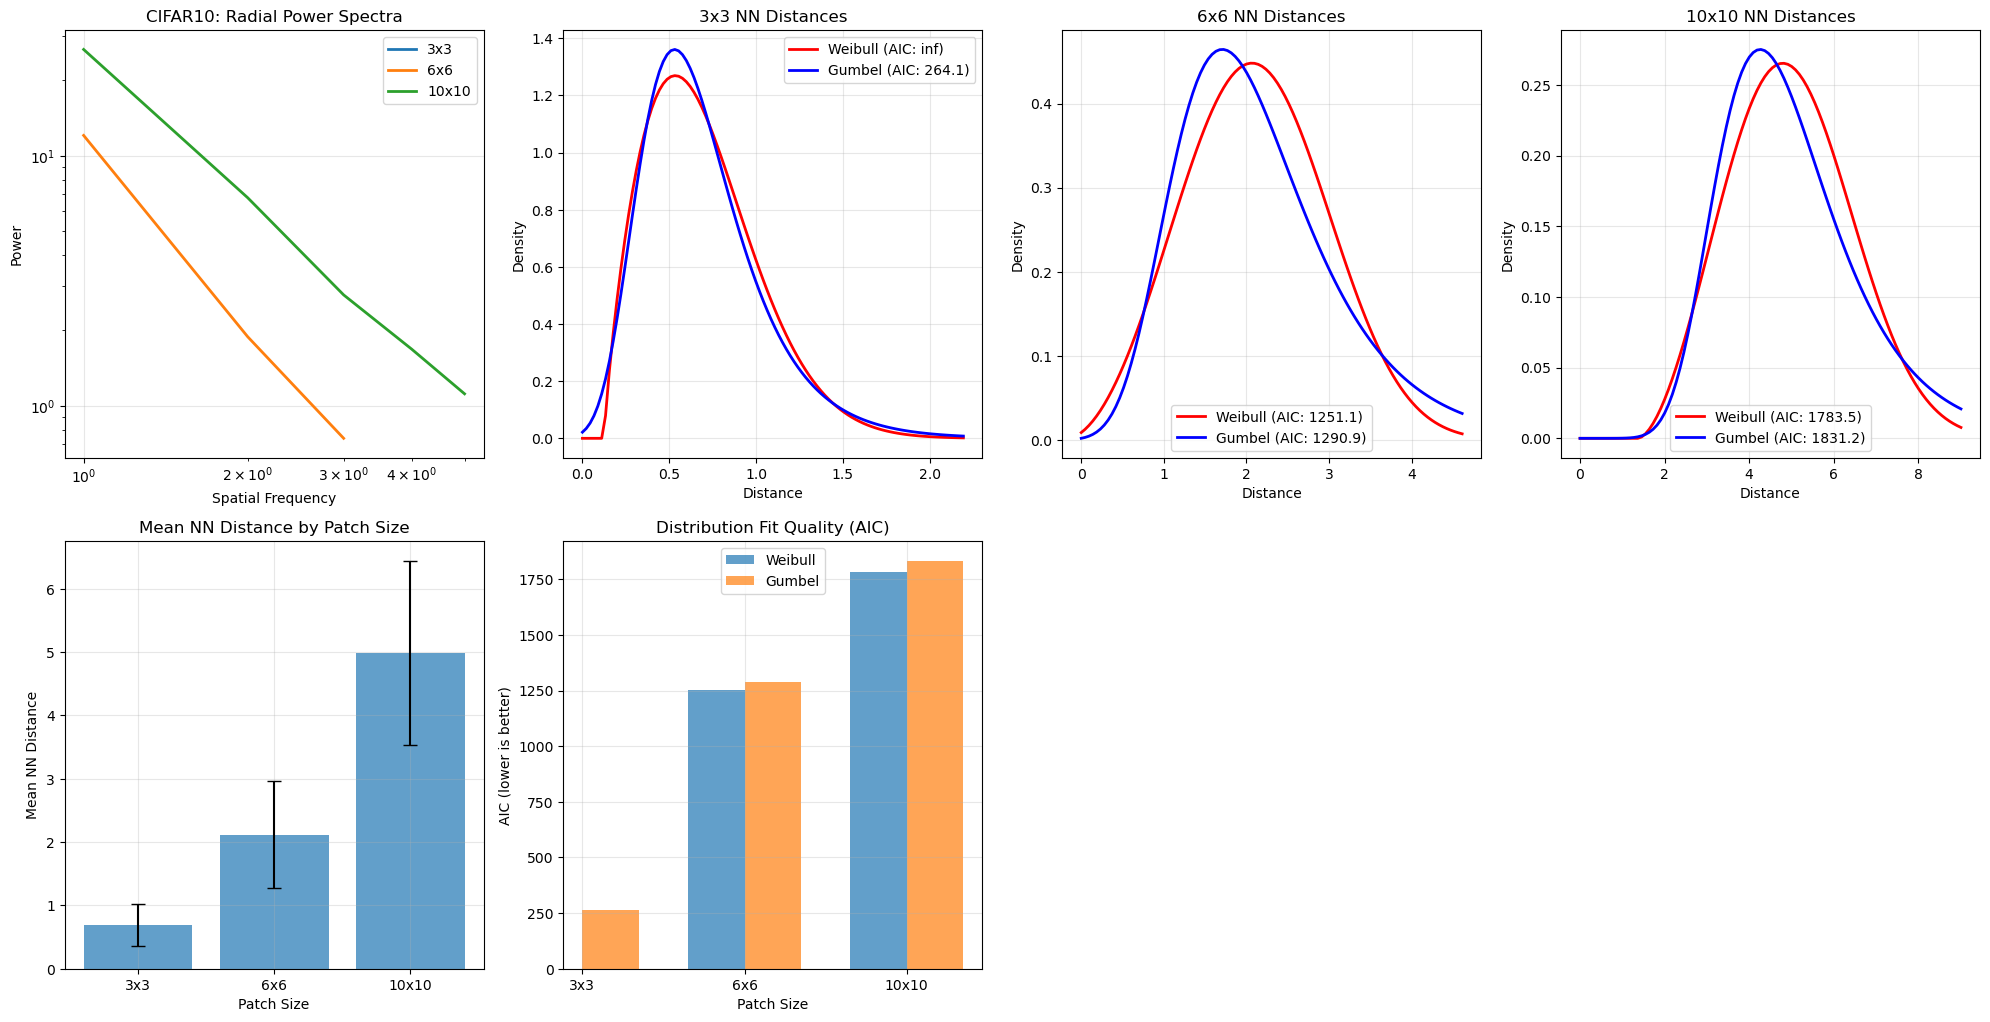

Completed analysis for cifar10

Loading fashion_mnist dataset...


100%|██████████| 26.4M/26.4M [00:28<00:00, 927kB/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.90MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Successfully loaded fashion_mnist
Dataset info: 60000 samples, 1 channels, 32x32 size

=== Analyzing FASHION_MNIST Dataset ===

Analyzing 3x3 patches...
Error processing fashion_mnist: too many values to unpack (expected 2)
Continuing with next dataset...

Loading celeba dataset...
Successfully loaded celeba
Dataset info: 162770 samples, 3 channels, 32x32 size

=== Analyzing CELEBA Dataset ===

Analyzing 3x3 patches...
  - Collected 500 patches
  - Mean NN distance: 0.6793
  - Std NN distance: 0.3420

Analyzing 6x6 patches...
  - Collected 500 patches
  - Mean NN distance: 2.2692
  - Std NN distance: 0.8153

Analyzing 10x10 patches...
  - Collected 500 patches
  - Mean NN distance: 5.1120
  - Std NN distance: 1.2627
Saved comprehensive plot to results\celeba\celeba_comprehensive_analysis.png
Saved detailed results to results\celeba\celeba_results.json


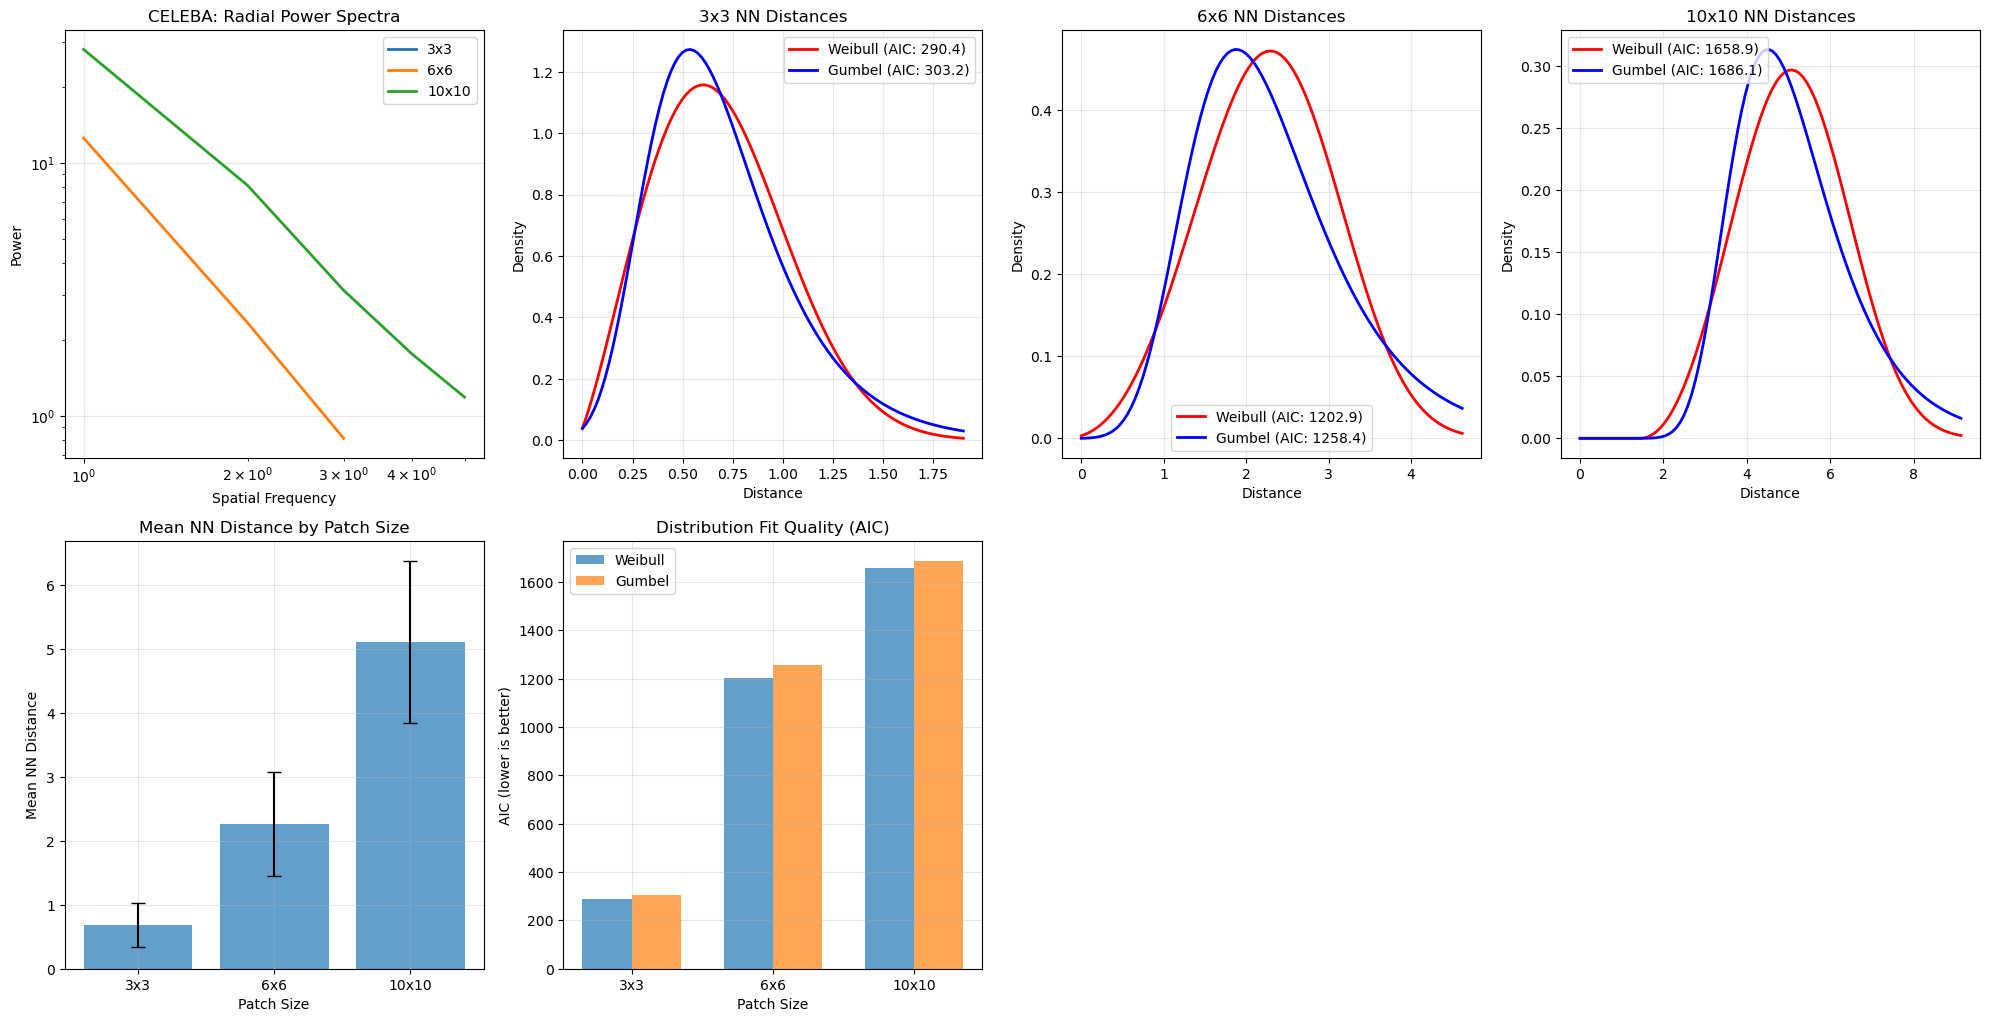

Completed analysis for celeba

Analysis complete!
Successfully analyzed 2 datasets: ['cifar10', 'celeba']
Results saved to individual dataset folders in ./results/


In [26]:
# Main Analysis: Run comprehensive analysis on all available datasets

# List of available datasets
available_datasets = ['mnist', 'cifar10', 'fashion_mnist', 'celeba']
patch_sizes = [3, 6, 10]

print("Starting comprehensive multi-dataset analysis...")
print(f"Datasets to analyze: {available_datasets}")
print(f"Patch sizes: {patch_sizes}")
print(f"Samples per analysis: 500")

all_results = {}

for dataset_name in available_datasets:
    try:
        print(f"\n{'='*50}")
        print(f"Loading {dataset_name} dataset...")
        
        # Load dataset
        if dataset_name == 'celeba':
            # CelebA might fail due to download issues, handle gracefully
            try:
                dataset, metadata = get_dataset(dataset_name, root='./data', train=True)
                print(f"Successfully loaded {dataset_name}")
            except Exception as e:
                print(f"Failed to load {dataset_name}: {e}")
                print("Skipping CelebA due to download limitations...")
                continue
        else:
            dataset, metadata = get_dataset(dataset_name, root='./data', train=True)
            print(f"Successfully loaded {dataset_name}")
        
        print(f"Dataset info: {len(dataset)} samples, {metadata['num_channels']} channels, {metadata['image_size']}x{metadata['image_size']} size")
        
        # Debug: Test a sample from the dataset
        print("Testing dataset sample...")
        try:
            sample = dataset[0]
            print(f"Sample type: {type(sample)}")
            if isinstance(sample, (list, tuple)):
                print(f"Sample length: {len(sample)}")
                if len(sample) >= 1:
                    print(f"Sample[0] (image) shape: {sample[0].shape}")
                if len(sample) >= 2:
                    print(f"Sample[1] (label) type: {type(sample[1])}")
            else:
                print(f"Sample shape: {sample.shape}")
        except Exception as e:
            print(f"Error testing dataset sample: {e}")
            import traceback
            traceback.print_exc()
            continue
        
        # Run analysis
        print("Starting patch analysis...")
        results = analyze_patch_distances(dataset, dataset_name, patch_sizes, num_samples=100)  # Reduced for debugging
        
        # Only create plots if we have results
        if results and results['patch_analyses']:
            print("Creating plots and saving results...")
            plot_and_save_results(results, dataset_name)
            
            # Store in global results
            all_results[dataset_name] = results
            print(f"Completed analysis for {dataset_name}")
        else:
            print(f"No valid results for {dataset_name} - skipping plot generation")
        
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        import traceback
        print("Full traceback:")
        traceback.print_exc()
        print("Continuing with next dataset...")
        continue

print(f"\n{'='*50}")
print("Analysis complete!")
print(f"Successfully analyzed {len(all_results)} datasets: {list(all_results.keys())}")
print("Results saved to individual dataset folders in ./results/")



CROSS-DATASET COMPARISON SUMMARY


KeyError: Dataset ImageFolder
    Number of datapoints: 162770
    Root location: ./data\celeba32
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

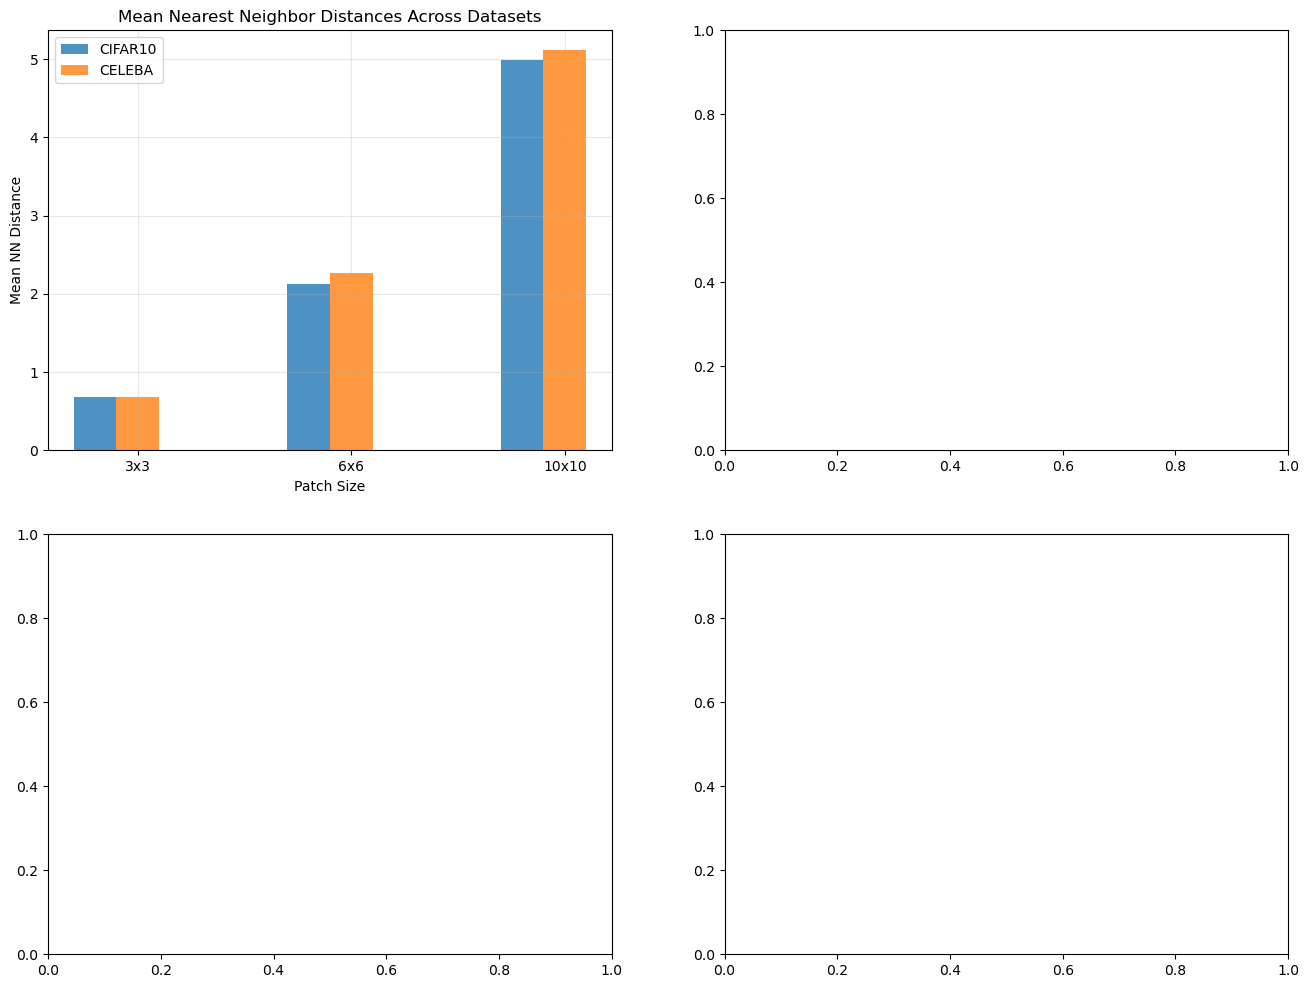

In [27]:
# Generate Cross-Dataset Comparison Summary

if len(all_results) > 1:
    print("\n" + "="*60)
    print("CROSS-DATASET COMPARISON SUMMARY")
    print("="*60)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Mean NN distances across datasets
    ax1 = axes[0, 0]
    datasets_compared = list(all_results.keys())
    patch_sizes = [3, 6, 10]
    
    x = np.arange(len(patch_sizes))
    width = 0.2
    
    for i, dataset_name in enumerate(datasets_compared):
        means = []
        for patch_size in patch_sizes:
            key = f'{patch_size}x{patch_size}'
            if key in all_results[dataset_name]['patch_analyses']:
                means.append(all_results[dataset_name]['patch_analyses'][key]['nn_distances_stats']['mean'])
            else:
                means.append(0)
        
        ax1.bar(x + i*width, means, width, label=dataset_name.upper(), alpha=0.8)
    
    ax1.set_xlabel('Patch Size')
    ax1.set_ylabel('Mean NN Distance')
    ax1.set_title('Mean Nearest Neighbor Distances Across Datasets')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels([f'{s}x{s}' for s in patch_sizes])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribution fit quality (AIC) comparison
    ax2 = axes[0, 1]
    weibull_better = {dataset: 0 for dataset in datasets_compared}
    gumbel_better = {dataset: 0 for dataset in datasets_compared}
    
    for dataset_name in datasets_compared:
        for patch_size in patch_sizes:
            key = f'{patch_size}x{patch_size}'
            if key in all_results[dataset_name]['patch_analyses']:
                fits = all_results[dataset_name]['patch_analyses'][key]['distribution_fits']
                weibull_aic = fits.get('weibull', {}).get('aic', np.inf)
                gumbel_aic = fits.get('gumbel', {}).get('aic', np.inf)
                
                if weibull_aic < gumbel_aic:
                    weibull_better[dataset] += 1
                elif gumbel_aic < weibull_aic:
                    gumbel_better[dataset] += 1
    
    datasets = list(weibull_better.keys())
    weibull_counts = list(weibull_better.values())
    gumbel_counts = list(gumbel_better.values())
    
    x = np.arange(len(datasets))
    ax2.bar(x - 0.2, weibull_counts, 0.4, label='Weibull Better', alpha=0.8, color='red')
    ax2.bar(x + 0.2, gumbel_counts, 0.4, label='Gumbel Better', alpha=0.8, color='blue')
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Number of Cases')
    ax2.set_title('Distribution Fit Quality (Lower AIC Wins)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([d.upper() for d in datasets])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Radial spectra comparison for 6x6 patches
    ax3 = axes[1, 0]
    for dataset_name in datasets_compared:
        if '6x6' in all_results[dataset_name]['radial_spectra']:
            spectrum = all_results[dataset_name]['radial_spectra']['6x6']['mean_spectrum']
            ax3.loglog(range(1, len(spectrum) + 1), spectrum, 
                      label=dataset_name.upper(), linewidth=2)
    
    ax3.set_xlabel('Spatial Frequency')
    ax3.set_ylabel('Power')
    ax3.set_title('Radial Power Spectra Comparison (6x6 Patches)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Coefficient of variation across patch sizes
    ax4 = axes[1, 1]
    for dataset_name in datasets_compared:
        cvs = []
        for patch_size in patch_sizes:
            key = f'{patch_size}x{patch_size}'
            if key in all_results[dataset_name]['patch_analyses']:
                stats = all_results[dataset_name]['patch_analyses'][key]['nn_distances_stats']
                cv = stats['std'] / stats['mean'] if stats['mean'] > 0 else 0
                cvs.append(cv)
            else:
                cvs.append(0)
        
        ax4.plot(patch_sizes, cvs, 'o-', label=dataset_name.upper(), linewidth=2, markersize=8)
    
    ax4.set_xlabel('Patch Size')
    ax4.set_ylabel('Coefficient of Variation')
    ax4.set_title('Distance Variability Across Patch Sizes')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save comparison plot
    comparison_path = os.path.join('results', 'cross_dataset_comparison.png')
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved cross-dataset comparison to {comparison_path}")
    
    plt.show()
    
    # Save consolidated results
    consolidated_path = os.path.join('results', 'consolidated_results.json')
    with open(consolidated_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    print(f"Saved consolidated results to {consolidated_path}")
    
    # Print summary statistics
    print("\nSUMMARY STATISTICS:")
    print("-" * 40)
    for dataset_name in datasets_compared:
        print(f"\n{dataset_name.upper()}:")
        for patch_size in patch_sizes:
            key = f'{patch_size}x{patch_size}'
            if key in all_results[dataset_name]['patch_analyses']:
                stats = all_results[dataset_name]['patch_analyses'][key]['nn_distances_stats']
                fits = all_results[dataset_name]['patch_analyses'][key]['distribution_fits']
                
                weibull_aic = fits.get('weibull', {}).get('aic', 'Failed')
                gumbel_aic = fits.get('gumbel', {}).get('aic', 'Failed')
                better_fit = 'Weibull' if (isinstance(weibull_aic, (int, float)) and 
                                          isinstance(gumbel_aic, (int, float)) and 
                                          weibull_aic < gumbel_aic) else 'Gumbel'
                
                print(f"  {key}: μ={stats['mean']:.4f}, σ={stats['std']:.4f}, Best fit: {better_fit}")

else:
    print("Only one dataset analyzed - skipping cross-dataset comparison")

print(f"\n{'='*60}")
print("COMPREHENSIVE ANALYSIS COMPLETE!")
print(f"Results available in ./results/ directory")
print(f"Analyzed datasets: {list(all_results.keys()) if all_results else 'None'}")


In [28]:
# Quick test for MNIST debugging
print("Testing MNIST dataset loading and processing...")

try:
    # Load MNIST dataset
    mnist_dataset, mnist_metadata = get_dataset('mnist', root='./data', train=True)
    print(f"MNIST loaded: {len(mnist_dataset)} samples")
    
    # Test a single sample
    sample = mnist_dataset[0]
    print(f"Sample type: {type(sample)}")
    print(f"Sample length: {len(sample)}")
    print(f"Image shape: {sample[0].shape}")
    print(f"Label: {sample[1]}")
    
    # Test RandomCrop
    test_crop = RandomCrop(3, 3)
    img = sample[0]
    print(f"Original image shape: {img.shape}")
    
    cropped = test_crop(img)
    print(f"Cropped image shape: {cropped.shape}")
    
    print("✓ MNIST test successful!")
    
except Exception as e:
    print(f"✗ MNIST test failed: {e}")
    import traceback
    traceback.print_exc()


Testing MNIST dataset loading and processing...
MNIST loaded: 60000 samples
Sample type: <class 'tuple'>
Sample length: 2
Image shape: torch.Size([1, 32, 32])
Label: 5
Original image shape: torch.Size([1, 32, 32])
Cropped image shape: torch.Size([1, 3, 3])
✓ MNIST test successful!
